![Agentic RAG](images/agenticRAG.png)

![Agentic RAG](images/whitePaperVsPractice.png)

The first image shows the flow from the official LangGraph documentation.
If I follow the official documentation, rewrite will not work properly, so I plan to make a slight modification.


In [44]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [45]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str
    
graph_builder = StateGraph(AgentState)

In [46]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환
    """
    query = state['query']  # state에서 사용자의 질문을 추출.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색.
    return {'context': docs}  # 검색된 문서를 포함한 state를 반환.

In [47]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [48]:
from langchain import hub

# RAG 프롬프트를 가져오기
generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환
    """
    context = state['context']  # state에서 문맥을 추출
    query = state['query']      # state에서 사용자의 질문을 추출
    
    # RAG 체인을 구성
    rag_chain = generate_prompt | llm
    
    # 질문과 문맥을 사용하여 응답을 생성
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response}  # 생성된 응답을 포함하는 state를 반환

In [49]:
from langchain import hub
from typing import Literal

# 문서 관련성 판단을 위한 프롬프트를 가져옴.
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['generate', 'rewrite']: 문서가 관련성이 높으면 'generate', 그렇지 않으면 'rewrite'를 반환
    """
    query = state['query']  # state에서 사용자의 질문을 추출
    context = state['context']  # state에서 문맥을 추출

    print(f'context == {context}')

    # 문서 관련성 판단 체인을 구성
    doc_relevance_chain = doc_relevance_prompt | llm

    # 질문과 문맥을 사용하여 문서의 관련성을 판단
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    print(f'response == {response}')

    # 관련성이 높으면 'generate'를 반환하고, 그렇지 않으면 'rewrite'를 반환
    # if response['Score'] == 1:
    #     return 'generate'

    # rewrite 횟수 세기
    state['rewrite_count'] = state.get('rewrite_count', 0) + 1
    
    # 2번 이상 rewrite했는데도 Score가 0 → 그냥 generate로
    if state['rewrite_count'] >= 2 or response['Score'] == 1:
        return 'generate'
    
    return 'rewrite'


In [50]:
query = "한국에서 직장인이 부담하는 소득세율은 어떻게 되나요?"

In [51]:
# rewrite 노드를 위한 코드

# generate: 문서가 관련성이 높음 → 바로 답변 생성 단계로 넘어감.
# rewrite: 문서가 관련성이 낮음 → 그냥 실패로 끝나는 게 아니라, 쿼리를 다시 써서(rewrite) 검색이 잘 되도록 해야 함.


from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 사전 정의: 특정 표현을 다른 표현으로 변환하기 위한 사전
dictionary = ['사람과 관련된 표현 -> 거주자']

# 프롬프트 템플릿을 생성. 사용자의 질문을 사전을 참고하여 변경.
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환.
    """
    query = state['query']  # state에서 사용자의 질문을 추출.
    
    # 리라이트 체인을 구성 프롬프트, LLM, 출력 파서를 연결.
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    # 질문을 변경.
    response = rewrite_chain.invoke({'query': query})
    
    return {'query': response}  # 변경된 질문을 포함하는 state를 반환.

In [52]:
# 노드 추가 엣지연결
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [53]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [54]:
graph = graph_builder.compile()

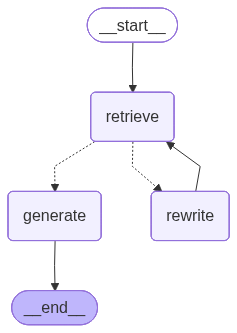

In [55]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
initial_state = {'query': '직장인 연봉 1억원 세금'}
graph.invoke(initial_state, config={'recursion_limit': 10})

context == [Document(metadata={'source': './documents/income_tax.txt'}, page_content='소득세법\n[시행 2025. 1. 1.] [법률 제20615호, 2024. 12. 31., 일반개정]\n기획재정부 (세제실세제과) 044-215-4312\n기획재정부 (소득세제과) 044-215-4216\n기획재정부 (유형세제과) 044-215-4233\n기획재정부 (소득세제관리과) 044-215-4217  \n제1장 총칙\n제정 2009. 12. 31.\n제2조(정의)\n이 법은 개인의 소득에 대하여 소득의 성격과 납세자의 부담능력 등에 따라 적정하게 과세함으로써 세부담의 형평을 도모하고 재정수입의 원활한 조달에 이바지함을 목적으로 한다.\n[본조신설 2009. 12. 31.]\n[종전 제1조는 제2조로 이동 <2009. 12. 31.>]  \n제2조(용어의 정의)\n① 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2010. 12. 27, 2014. 12. 23, 2018. 12. 31.>\n1. “거주자”란 국내에 주소를 두거나 183일 이상에 해당하는 거소를 두 개인을 말한다.\n2. “비거주자”란 거주자가 아닌 개인을 말한다.\n3. “국내법인”이란 법인세법 제2조제1호에 따른 내국법인을 말한다.\n4. “외국법인”이란 법인세법 제2조제3호에 따른 외국법인을 말한다.\n5. “사업자”란 사업소의 있는 거주자를 말한다.\n6. 제1항에 따른 소득·가소득자·비거주자의 구분은 대통령령으로 정한다.\n[본조신설 2009. 12. 31.]  \n제2조(납세의무)\n구분\n1. 거주자\n2. 비거주자로서 국내원천소득(國內源泉所得)이 있는 개인\n3. 다음 각 호의 어느 하나에 해당하는 자는 이 법에 따라 원천징수한 소득세를 납부할 의무를 진다.\n   1. 거주자\n   2. 비거주자\n   3. 법인\n   4. 외국법인인 국내접점 또는 국내영업소(出張所, 그 밖에 이에 준하는 것을 포함한다. 이하 같

GraphRecursionError: Recursion limit of 3 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT